# **Задача предсказания наличия сердечнососудистых заболеваний**


In [99]:
from google.colab import files
import zipfile

import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.metrics import balanced_accuracy_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV

from imblearn.over_sampling import SMOTE
from collections import Counter

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_confusion_matrix

RANDOM_STATE=42

## **Загрузка данных**


In [100]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [101]:
# Здесь требуется загрузить kaggle token
files.upload()

Saving kaggle.json to kaggle (2).json


{'kaggle.json': b'{"username":"raincwail","key":"26460115e65965329a645f55946694e0"}'}

In [102]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [103]:
!kaggle datasets download -d kamilpytlak/personal-key-indicators-of-heart-disease

personal-key-indicators-of-heart-disease.zip: Skipping, found more recently modified local copy (use --force to force download)


In [104]:
zip_ref = zipfile.ZipFile('personal-key-indicators-of-heart-disease.zip', 'r')
zip_ref.extractall('files')
zip_ref.close()

In [105]:
data_raw=pd.read_csv('files/heart_2020_cleaned.csv')

## **Задача**

Задача заключается в предсказании наличия ишемической болезни сердца (CHD) или инфаркта миокарда (MI). Целевая переменная - HeartDisease - представляет из себя бинарный показатель (0 - болезней нет, 1 - человек болен).

- `HeartDisease - Categorical Binary`: Болен ли человек ишемической болезнью сердца или инфарктом миокарда.
- `BMI - Continuous  Numertical`: Индекс массы тела.
- `Smoking - Categorical Binary`: Прокурил ли человек хотя бы 100 сигарет за жизнь.
- `AlcoholDrinking - Categorical Binary`: Степень принятия алкоголя (мужчины, пьющие более 14 напитков в неделю, и женщины, пьющие более 7 напитков в неделю)
- `Stroke - Categorical Binary`: Говори ли о том, что мог случиться/действительно случался инсульт.
- `PhysicalHealth - Continuous Numertical`: Степень физического состояния (сколько из последних 30 дней (ваше) физическое состояние можно было бы назвать плохим).
- `MentalHealth - Continuous Numertical`: Степень ментального состояния (сколько из последних 30 дней (ваше) ментальное состояние можно было бы назвать плохим).
- `DiffWalking - Categorical Binary`: Сложно ли ходить/подниматься по лестницам.
- `Sex - Categorical`: Мужчина/Женщина.
- `AgeCategory - Sorted Categorical`: Возрастная категория.
- `Race - Nonsorted Categorical`: Раса/Этническая принадлежность.
- `Diabetic - Nonsorted Categorical`: Степень наличия диабета.
- `PhysicalActivity - Categorical Binary`: Степень доп. физической нагрузки (за последние 30 дней (вы) занимались физической активностью, помимо работы).
- `GenHealth - Sorted Categorical`: Категория оценки здоровья.
- `SleepTime - Continuous Numertical`: Среднее количество сна из 24 часов.
- `Asthma - Categorical Binary`: Говори ли о том, что у вас может быть/действительно имеется астма.
- `KidneyDisease - Categorical Binary`: Имеется ли болезнь почек (исключая камни в почках, инфекции мочевого пузыря и недержание).
- `SkinCancer - Categorial Binary`: Говори ли о том, что у вас может быть/действительно имеется рак кожи.


Более приятный вид типов данных:

In [106]:
data_types = pd.DataFrame({"Column": data_raw.columns, "DataType": ['Categorical Binary', 'Continuous Numerical', 'Categorical Binary', 'Categorical Binary', 'Categorical Binary', 'Continuous Numerical', 'Continuous Numerical', 'Categorical Binary', 'Categorical', 'Sorted Categorical', 'Nonsorted Categorical', 'Nonsorted Categorical', 'Categorical Binary', 'Sorted Categorical', 'Continuous Numerical', 'Categorical Binary', 'Categorical Binary', 'Categorical Binary']})
data_types

,Column,DataType
0,HeartDisease,Categorical Binary
1,BMI,Continuous Numerical
2,Smoking,Categorical Binary
3,AlcoholDrinking,Categorical Binary
4,Stroke,Categorical Binary
5,PhysicalHealth,Continuous Numerical
6,MentalHealth,Continuous Numerical
7,DiffWalking,Categorical Binary
8,Sex,Categorical
9,AgeCategory,Sorted Categorical


## **Описание данных**

### **Первый взгляд**

In [107]:
data_raw.head(15)

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No
5,Yes,28.87,Yes,No,No,6.0,0.0,Yes,Female,75-79,Black,No,No,Fair,12.0,No,No,No
6,No,21.63,No,No,No,15.0,0.0,No,Female,70-74,White,No,Yes,Fair,4.0,Yes,No,Yes
7,No,31.64,Yes,No,No,5.0,0.0,Yes,Female,80 or older,White,Yes,No,Good,9.0,Yes,No,No
8,No,26.45,No,No,No,0.0,0.0,No,Female,80 or older,White,"No, borderline diabetes",No,Fair,5.0,No,Yes,No
9,No,40.69,No,No,No,0.0,0.0,Yes,Male,65-69,White,No,Yes,Good,10.0,No,No,No


In [108]:
data_raw.shape

(319795, 18)

In [109]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  object 
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  object 
 3   AlcoholDrinking   319795 non-null  object 
 4   Stroke            319795 non-null  object 
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  object 
 8   Sex               319795 non-null  object 
 9   AgeCategory       319795 non-null  object 
 10  Race              319795 non-null  object 
 11  Diabetic          319795 non-null  object 
 12  PhysicalActivity  319795 non-null  object 
 13  GenHealth         319795 non-null  object 
 14  SleepTime         319795 non-null  float64
 15  Asthma            319795 non-null  object 
 16  KidneyDisease     31

In [110]:
columns = list(set(data_raw.columns) - {'BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime'})
pd.DataFrame({"Column Name": columns, "Unique Values": [data_raw[i].unique() for i in columns]})


,Column Name,Unique Values
0,DiffWalking,"[No, Yes]"
1,Diabetic,"[Yes, No, No, borderline diabetes, Yes (during..."
2,HeartDisease,"[No, Yes]"
3,AlcoholDrinking,"[No, Yes]"
4,Smoking,"[Yes, No]"
5,Sex,"[Female, Male]"
6,Race,"[White, Black, Asian, American Indian/Alaskan ..."
7,PhysicalActivity,"[Yes, No]"
8,Asthma,"[Yes, No]"
9,AgeCategory,"[55-59, 80 or older, 65-69, 75-79, 40-44, 70-7..."


In [111]:
data_raw.describe()[1:].T.style.background_gradient(cmap='Blues')

,mean,std,min,25%,50%,75%,max
BMI,28.325399,6.356100,12.020000,24.030000,27.340000,31.420000,94.850000
PhysicalHealth,3.371710,7.950850,0.000000,0.000000,0.000000,2.000000,30.000000
MentalHealth,3.898366,7.955235,0.000000,0.000000,0.000000,3.000000,30.000000
SleepTime,7.097075,1.436007,1.000000,6.000000,7.000000,8.000000,24.000000


In [112]:
data_raw.corr().T.style.background_gradient(cmap='Blues')

,BMI,PhysicalHealth,MentalHealth,SleepTime
BMI,1.000000,0.109788,0.064131,-0.051822
PhysicalHealth,0.109788,1.000000,0.287987,-0.061387
MentalHealth,0.064131,0.287987,1.000000,-0.119717
SleepTime,-0.051822,-0.061387,-0.119717,1.000000


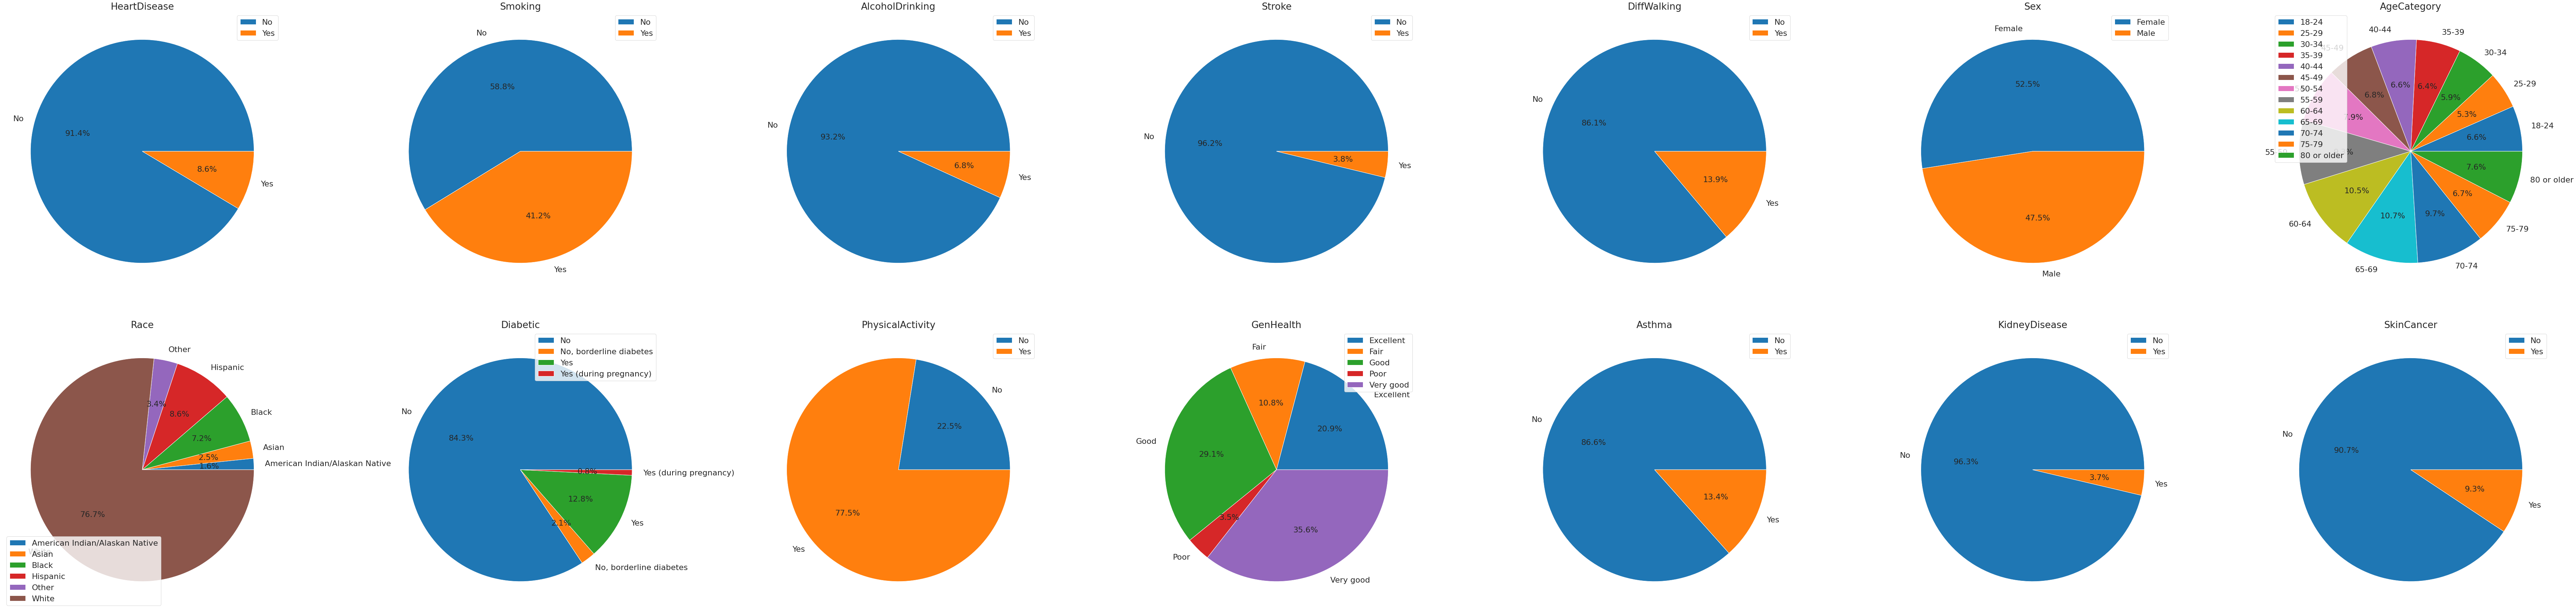

In [113]:
matplotlib.rcParams.update({'font.size': 22})
fig, axes = plt.subplots(nrows=2, ncols=7, figsize=(100, 25))
for col, data_col in enumerate(data_types[data_types['DataType'] != 'Continuous Numerical']['Column']):
  data_raw.groupby(data_col).count().plot(kind='pie', autopct='%1.1f%%', y='BMI', title=data_col, ax=axes[col // 7, col % 7])
  axes[col // 7, col % 7].set_ylabel("")
fig.tight_layout()
matplotlib.rcParams.update({'font.size': 10})


### **Комментарий**

**Первый взгляд**

Первое, что бросается в глаза, очень сильный дисбаланс классов в целевой переменной (лишь ~9% данных принадлежат классу больных) - с этим придётся что-то сделать.

Огромный процент людей курит, малое количество людей потребляет алкоголь (что кажется немного странным).

Выборка +- минус равномерно распределена относительно пола, а также достаточно разношёрстна по возрастной категории. Того же нельзя сказать про этническую принадлежность респодентов.

БОльшая часть людей не имеют диабета, астмы, болезней почек и рака кожи, хотя значительный процент всё же обладает диабетом (12.8 + 2.3%), астмой (13.4%) и раком кожи (9.3%).

Что любопытно, огромная часть людей занимается доп. физической активностью и сообщает, что здоровье находится на уровне Хорошо - Мега хорошо.

**Что хочется проверить**

- Влияние этих и числовых признаков на целевой, в частности:
  - все числовые признаки
  - распределение больных по полу
  - прочим болезням (диабет, астма, болезнь почек, рак кожи)
  - физ. активности
  - общей оценки здоровья.
- Важность всех признаков/Можно ли безопасно избавиться от некоторых

### **Влияние признаков** - Числовые признаки

In [114]:
def plot_kde(column_to_analyze: str, ax):
  sns.kdeplot(data_raw[data_raw["HeartDisease"]=='No'][column_to_analyze], shade=True, label="No HeartDisease", ax = ax)
  sns.kdeplot(data_raw[data_raw["HeartDisease"]=='Yes'][column_to_analyze], shade=True, label="HeartDisease", ax = ax)
  ax.set_xlabel(column_to_analyze)
  ax.set_ylabel("Frequency")
  ax.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)

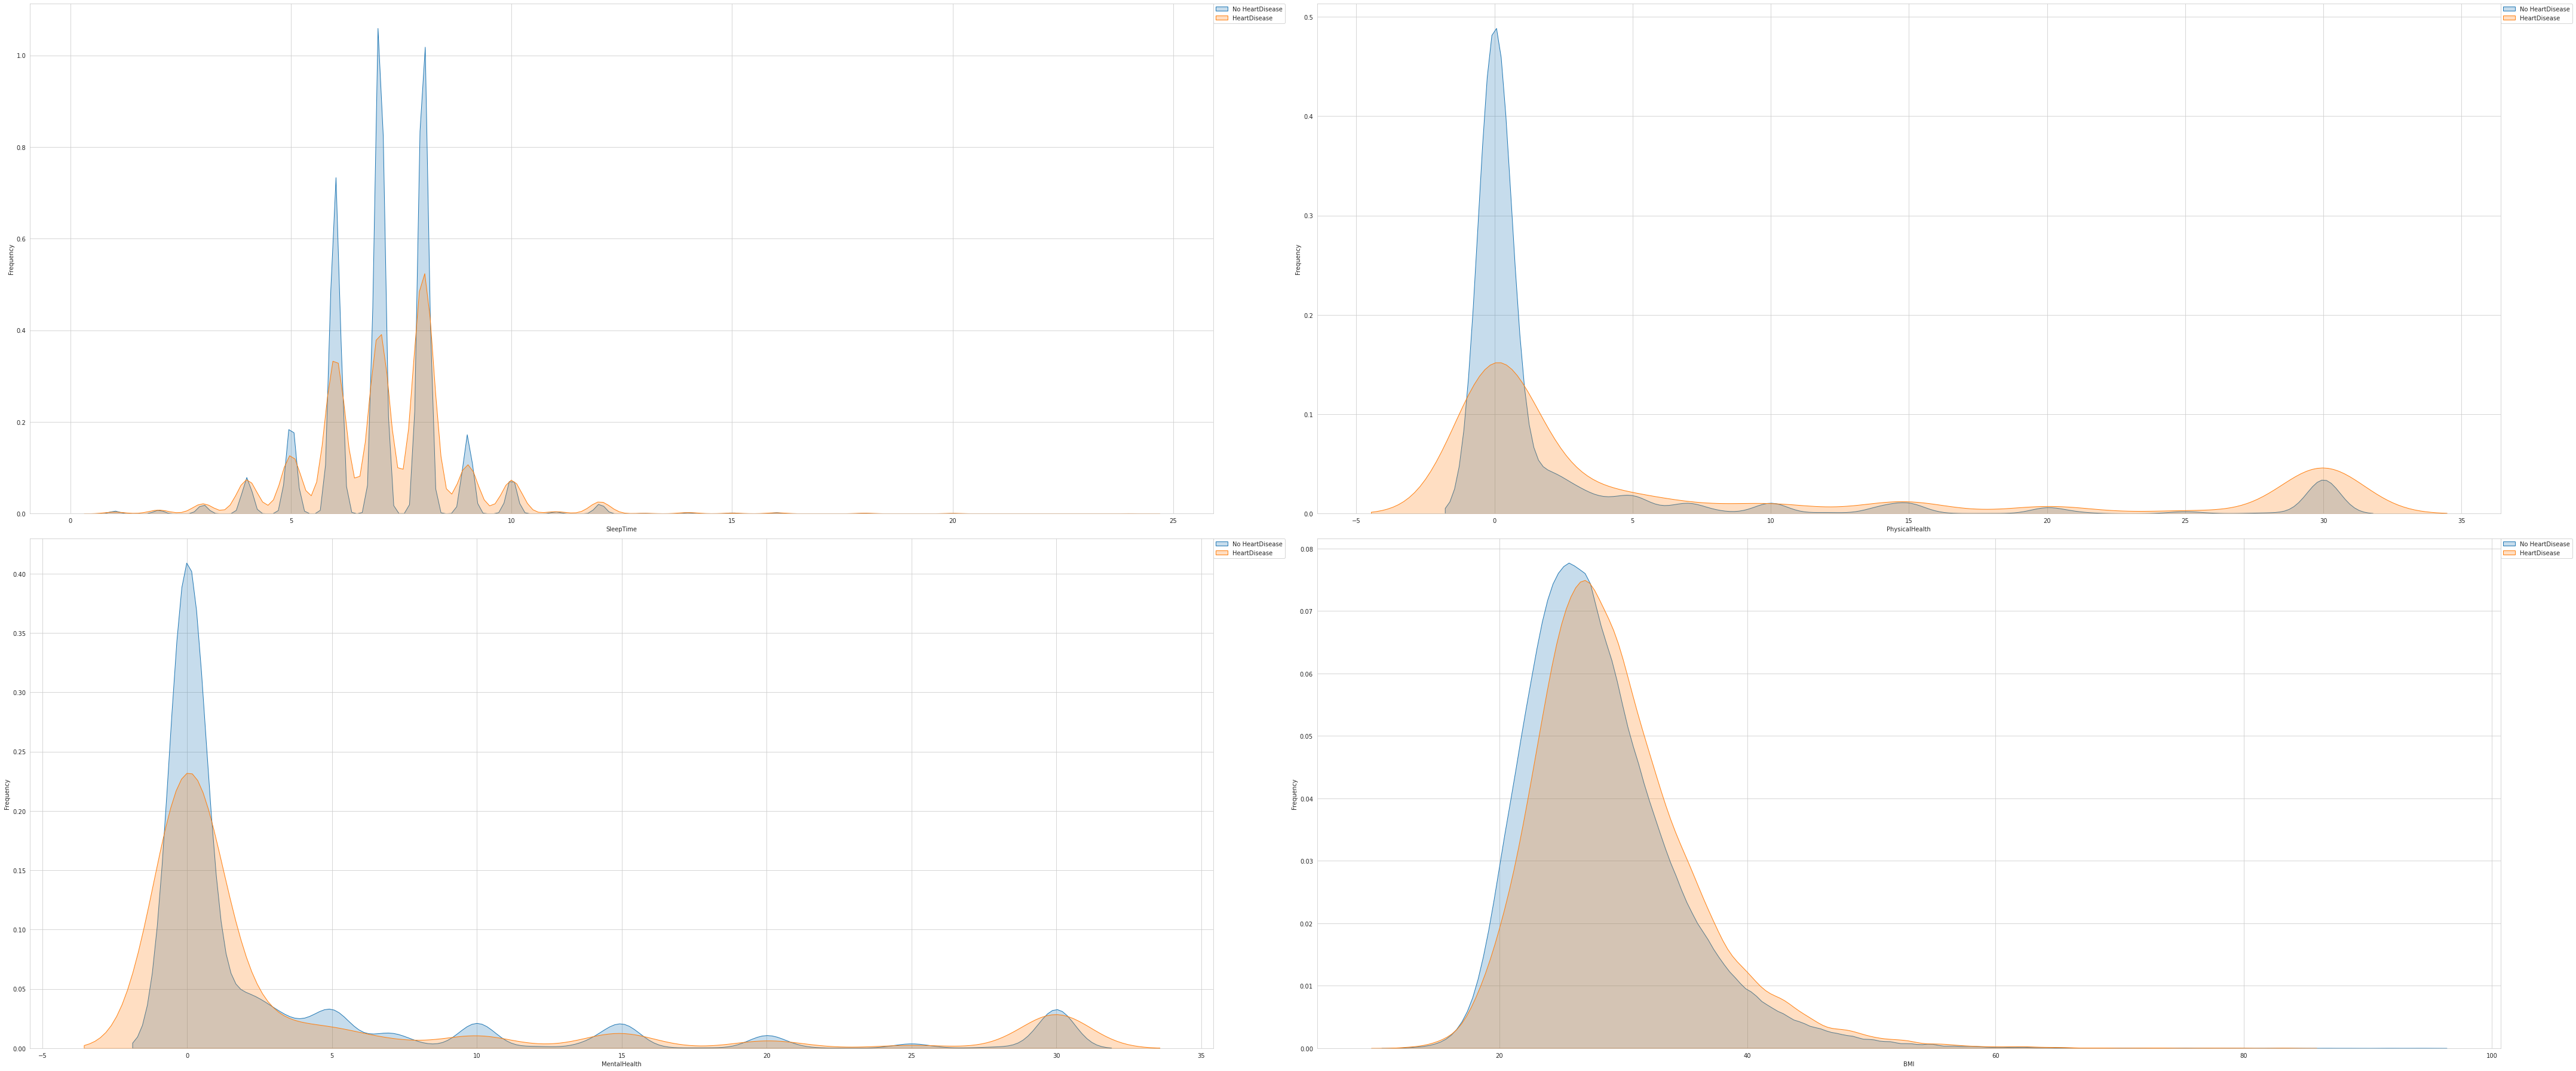

In [115]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(60, 25))

plot_kde("SleepTime", axes[0, 0])
plot_kde("PhysicalHealth", axes[0, 1])
plot_kde("MentalHealth", axes[1, 0])
plot_kde("BMI", axes[1, 1])

fig.tight_layout()
fig.show()

### **Комментарий**

Любопытно, что нет особо очевидных отклонений от распределений. Тренд для больных будто копирует тренд здоровых.

Из исключений можно подметить в графиках физического и ментального здоровья - среди людей, отмечающих столкновения с физическими/ментальными проблемами все 30 из 30 дней, значительно больше больных.

Судя по всему, их опасения и проблемы напрямую связаны с сердечно-сосудистыми заболеваниями. Хотя это кажется странным, возможно, дело в чём-то ещё.

Upd. Также любопытно, что людей с сердечно-сосудистыми заболеваниями становится больше здоровых, стоит отходить от "нормальных" и часто указанных часов сна (1 - 4 часа сна, 10+ часов сна)

### **Влияние признаков** - Распределение по полу



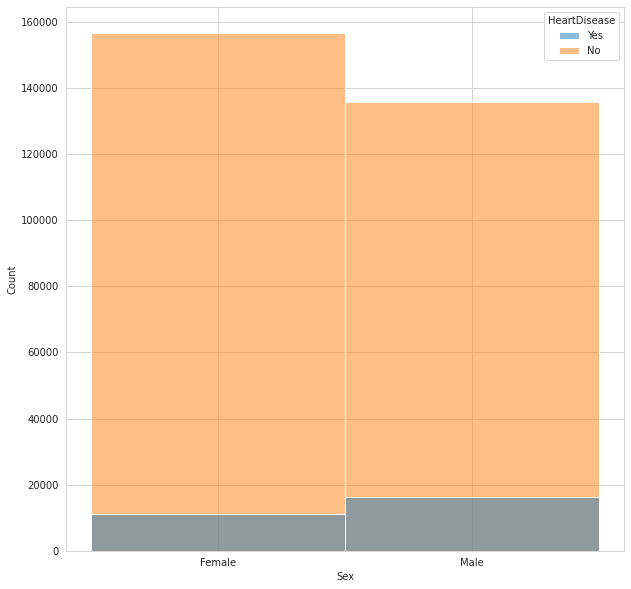

In [116]:
_, ax = plt.subplots(figsize=(10, 10))
sns.histplot(data=data_raw, ax=ax, x="Sex", hue="HeartDisease", hue_order=["Yes", "No"])

In [117]:
fem_perc = data_raw.loc[(data_raw["HeartDisease"] == 'Yes') & (data_raw["Sex"] == "Female")].shape[0]/data_raw.loc[data_raw["Sex"] == "Female"].shape[0]
male_perc = data_raw.loc[(data_raw["HeartDisease"] == 'Yes') & (data_raw["Sex"] == "Male")].shape[0]/data_raw.loc[data_raw["Sex"] == "Male"].shape[0]
print(f"The percentage of men having (CHD) or (MI): {male_perc}")
print(f"The percentage of women having (CHD) or (MI): {fem_perc}")

The percentage of men having (CHD) or (MI): 0.10618461740904007
The percentage of women having (CHD) or (MI): 0.06694675367241738


### **Комментарий**

Интересное явление: число мужчин в выборке значительно меньше, однако процент сердечно больных среди мужчин значительно выше, чем среди женщин.

Наконец-то причина того, почему женщины живут дольше мужчин найдена, ура :(

### **Влияние признаков** - Распределение по болезням


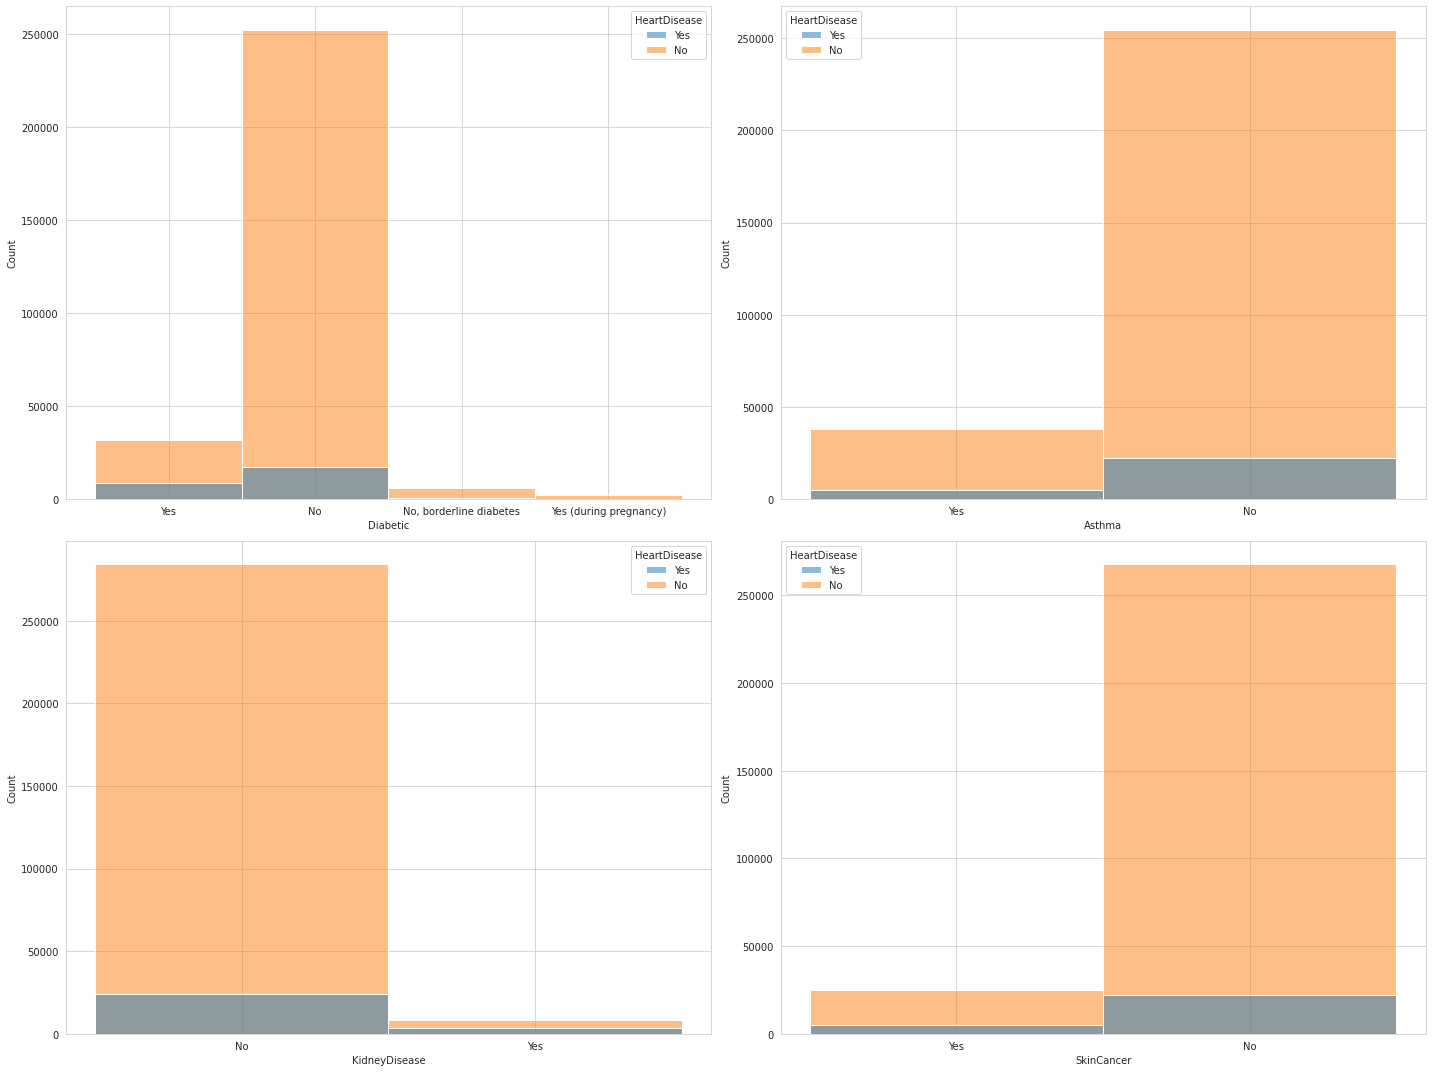

In [118]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,15))

sns.histplot(data=data_raw, x="Diabetic", hue="HeartDisease", hue_order=["Yes", "No"], ax=axes[0, 0])
sns.histplot(data=data_raw, x="Asthma", hue="HeartDisease", hue_order=["Yes", "No"], ax=axes[0, 1])
sns.histplot(data=data_raw, x="KidneyDisease", hue="HeartDisease", hue_order=["Yes", "No"], ax=axes[1, 0])
sns.histplot(data=data_raw, x="SkinCancer", hue="HeartDisease", hue_order=["Yes", "No"], ax=axes[1, 1])

fig.tight_layout()

### **Комментарий**

Судя по всему, ничего особо интересного. Тренд для больных и здоровых повторяет тренд для самого заболевания (отношение больных к здоровым, скажем, астмой примерно повторяет отношение больных к здоровым сердечно-сосудистыми).

### **Влияние признаков** - Распределение по физической активности и общей оценке здоровья

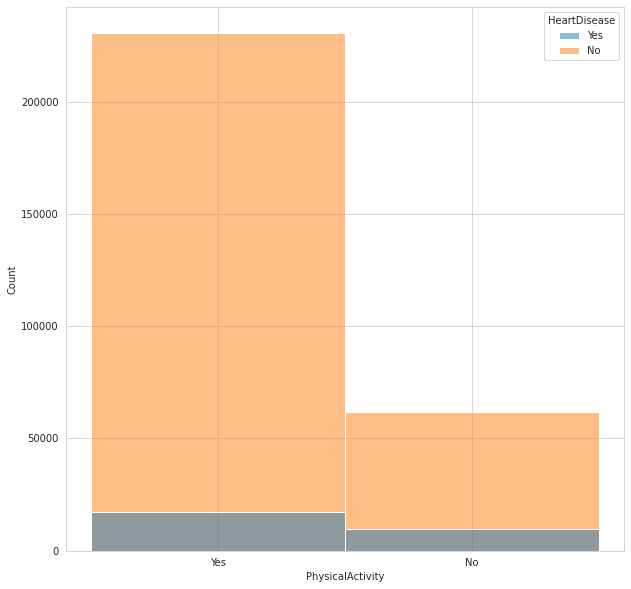

In [119]:
_, ax = plt.subplots(figsize=(10, 10))
sns.histplot(data=data_raw, ax=ax, x="PhysicalActivity", hue="HeartDisease", hue_order=["Yes", "No"])

In [120]:
extra_perc = data_raw.loc[(data_raw["HeartDisease"] == 'Yes') & (data_raw["PhysicalActivity"] == "Yes")].shape[0]/data_raw.loc[data_raw["PhysicalActivity"] == "Yes"].shape[0]
no_extra_perc = data_raw.loc[(data_raw["HeartDisease"] == 'Yes') & (data_raw["PhysicalActivity"] == "No")].shape[0]/data_raw.loc[data_raw["PhysicalActivity"] == "No"].shape[0]
print(f"The percentage of people doing extra physical activity having (CHD) or (MI): {extra_perc}")
print(f"The percentage of people not doing extra physical activity having (CHD) or (MI): {no_extra_perc}")

The percentage of people doing extra physical activity having (CHD) or (MI): 0.07053239069677404
The percentage of people not doing extra physical activity having (CHD) or (MI): 0.13758734931373368


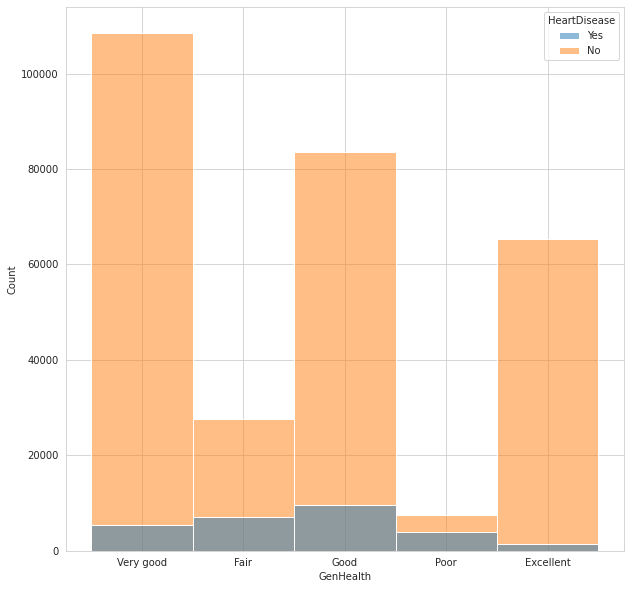

In [121]:
_, ax = plt.subplots(figsize=(10, 10))
sns.histplot(data=data_raw, ax=ax, x="GenHealth", hue="HeartDisease", hue_order=["Yes", "No"])

### **Комментарий**

Чего и следовало ожидать - доп. физическая нагрузка это плюс -> риск обладания середечно-сосудистым среди людей, занимающимися доп. физической нагрузкой, значительно ниже (на целых 5%).

Менее очевидные результаты на распределении по GenHealth. Несмотря на то, что Good - не самый полный класс признака, количество больных в нём значительно выше, чем в остальных классах. Возможно люди не могут здраво отнести себя в категорию Fair - Poor или считают, что не могут отнести себя в категории Very Good - Excellent.

### **Доп. комментарий**

Предположения:

Самыми важными признаками будут являться признаки, связанные с физическим восприятием (скажем, GenHealth и PhysicalActivity). Менее важными могут оказаться пол, раса, наличие прочих болезней (кроме диабета, наверное).

## **Обработка категориальных и бинарных признаков**

In [122]:
data = data_raw.copy()

In [123]:
data_types[data_types['DataType'] != 'Continuous Numerical']

,Column,DataType
0,HeartDisease,Categorical Binary
2,Smoking,Categorical Binary
3,AlcoholDrinking,Categorical Binary
4,Stroke,Categorical Binary
7,DiffWalking,Categorical Binary
8,Sex,Categorical
9,AgeCategory,Sorted Categorical
10,Race,Nonsorted Categorical
11,Diabetic,Nonsorted Categorical
12,PhysicalActivity,Categorical Binary


In [124]:
data

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319790,Yes,27.41,Yes,No,No,7.0,0.0,Yes,Male,60-64,Hispanic,Yes,No,Fair,6.0,Yes,No,No
319791,No,29.84,Yes,No,No,0.0,0.0,No,Male,35-39,Hispanic,No,Yes,Very good,5.0,Yes,No,No
319792,No,24.24,No,No,No,0.0,0.0,No,Female,45-49,Hispanic,No,Yes,Good,6.0,No,No,No
319793,No,32.81,No,No,No,0.0,0.0,No,Female,25-29,Hispanic,No,No,Good,12.0,No,No,No


### **Обработка текстовых бинарных значений**

In [125]:
for i in data_types[data_types['DataType'] == 'Categorical Binary'].Column:
  data[i] = data[i].eq('Yes').mul(1)

In [126]:
data

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,0,16.60,1,0,0,3.0,30.0,0,Female,55-59,White,Yes,1,Very good,5.0,1,0,1
1,0,20.34,0,0,1,0.0,0.0,0,Female,80 or older,White,No,1,Very good,7.0,0,0,0
2,0,26.58,1,0,0,20.0,30.0,0,Male,65-69,White,Yes,1,Fair,8.0,1,0,0
3,0,24.21,0,0,0,0.0,0.0,0,Female,75-79,White,No,0,Good,6.0,0,0,1
4,0,23.71,0,0,0,28.0,0.0,1,Female,40-44,White,No,1,Very good,8.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319790,1,27.41,1,0,0,7.0,0.0,1,Male,60-64,Hispanic,Yes,0,Fair,6.0,1,0,0
319791,0,29.84,1,0,0,0.0,0.0,0,Male,35-39,Hispanic,No,1,Very good,5.0,1,0,0
319792,0,24.24,0,0,0,0.0,0.0,0,Female,45-49,Hispanic,No,1,Good,6.0,0,0,0
319793,0,32.81,0,0,0,0.0,0.0,0,Female,25-29,Hispanic,No,0,Good,12.0,0,0,0


### **Обработка порядковых текстовых значений**

In [127]:
age_vals = sorted(data['AgeCategory'].unique())
data.replace({'AgeCategory': dict(zip(age_vals, range(1, len(age_vals) + 1)))}, inplace=True)
data.replace({'GenHealth': {'Poor': 1, 'Fair': 2, 'Good': 3, 'Very good': 4, 'Excellent': 5}}, inplace=True)


In [128]:
data

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,0,16.60,1,0,0,3.0,30.0,0,Female,8,White,Yes,1,4,5.0,1,0,1
1,0,20.34,0,0,1,0.0,0.0,0,Female,13,White,No,1,4,7.0,0,0,0
2,0,26.58,1,0,0,20.0,30.0,0,Male,10,White,Yes,1,2,8.0,1,0,0
3,0,24.21,0,0,0,0.0,0.0,0,Female,12,White,No,0,3,6.0,0,0,1
4,0,23.71,0,0,0,28.0,0.0,1,Female,5,White,No,1,4,8.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319790,1,27.41,1,0,0,7.0,0.0,1,Male,9,Hispanic,Yes,0,2,6.0,1,0,0
319791,0,29.84,1,0,0,0.0,0.0,0,Male,4,Hispanic,No,1,4,5.0,1,0,0
319792,0,24.24,0,0,0,0.0,0.0,0,Female,6,Hispanic,No,1,3,6.0,0,0,0
319793,0,32.81,0,0,0,0.0,0.0,0,Female,2,Hispanic,No,0,3,12.0,0,0,0


### **Комментарий**

Считаю, что данные признаки дадут большую пользу, имей они порядок. Поэтому заменяю их на соответствующие числовые значения, а не использую one-hot.

### **Обработка оставшихся текстовых признаков**

Всё, что осталось, заменяем при помощи one-hot encoding'а.

In [129]:
for i in data.columns[(data.dtypes == object).tolist()]:
  one_hot = pd.get_dummies(data[i])
  data.drop(i, axis=1, inplace=True)
  data = data.join(one_hot)


In [130]:
data

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,AgeCategory,PhysicalActivity,...,American Indian/Alaskan Native,Asian,Black,Hispanic,Other,White,No,"No, borderline diabetes",Yes,Yes (during pregnancy)
0,0,16.60,1,0,0,3.0,30.0,0,8,1,...,0,0,0,0,0,1,0,0,1,0
1,0,20.34,0,0,1,0.0,0.0,0,13,1,...,0,0,0,0,0,1,1,0,0,0
2,0,26.58,1,0,0,20.0,30.0,0,10,1,...,0,0,0,0,0,1,0,0,1,0
3,0,24.21,0,0,0,0.0,0.0,0,12,0,...,0,0,0,0,0,1,1,0,0,0
4,0,23.71,0,0,0,28.0,0.0,1,5,1,...,0,0,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319790,1,27.41,1,0,0,7.0,0.0,1,9,0,...,0,0,0,1,0,0,0,0,1,0
319791,0,29.84,1,0,0,0.0,0.0,0,4,1,...,0,0,0,1,0,0,1,0,0,0
319792,0,24.24,0,0,0,0.0,0.0,0,6,1,...,0,0,0,1,0,0,1,0,0,0
319793,0,32.81,0,0,0,0.0,0.0,0,2,0,...,0,0,0,1,0,0,1,0,0,0


### **Проверка типов данных**

Проверяем, не забыли ли заменить что-либо ещё.

In [131]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 27 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   HeartDisease                    319795 non-null  int64  
 1   BMI                             319795 non-null  float64
 2   Smoking                         319795 non-null  int64  
 3   AlcoholDrinking                 319795 non-null  int64  
 4   Stroke                          319795 non-null  int64  
 5   PhysicalHealth                  319795 non-null  float64
 6   MentalHealth                    319795 non-null  float64
 7   DiffWalking                     319795 non-null  int64  
 8   AgeCategory                     319795 non-null  int64  
 9   PhysicalActivity                319795 non-null  int64  
 10  GenHealth                       319795 non-null  int64  
 11  SleepTime                       319795 non-null  float64
 12  Asthma          

## **Обработка пропущенных данных**

In [132]:
data.isna().any()

HeartDisease                      False
BMI                               False
Smoking                           False
AlcoholDrinking                   False
Stroke                            False
PhysicalHealth                    False
MentalHealth                      False
DiffWalking                       False
AgeCategory                       False
PhysicalActivity                  False
GenHealth                         False
SleepTime                         False
Asthma                            False
KidneyDisease                     False
SkinCancer                        False
Female                            False
Male                              False
American Indian/Alaskan Native    False
Asian                             False
Black                             False
Hispanic                          False
Other                             False
White                             False
No                                False
No, borderline diabetes           False


Судя по всему данные уже были почищены, т.е. обработку пропусков можно упустить.

## **Разбивка данных на трейн и тест**


In [133]:
X_train, X_test, y_train, y_test = train_test_split(data.loc[:, data.columns != 'HeartDisease'], data.loc[:, 'HeartDisease'], test_size=0.33, random_state=RANDOM_STATE)

UPD. Из будущего - проблема, упомянутая чуть раньше, наконец дала о себе знать.
Нам необходим какой-то баланс среди этих классов, поскольку многие модели начинают переобучаться под выдачу лишь одного класса (модели, основанные на деревьях в частности, такое любят).

Мы хотим совершать ошибки второго рода гораздо реже, поскольку их последствия гораздо более опасны в данной задаче - для этого воспользуемся методом оверсамплинга из библиотеки imblearn.

In [134]:
over_sampler = SMOTE(k_neighbors=10)
X_res, y_res = over_sampler.fit_resample(X_train, y_train)
print(f"Training target statistics: {Counter(y_res)}")
print(f"Testing target statistics: {Counter(y_test)}")

Training target statistics: Counter({0: 196037, 1: 196037})
Testing target statistics: Counter({0: 96385, 1: 9148})


## **Определение важности признаков**

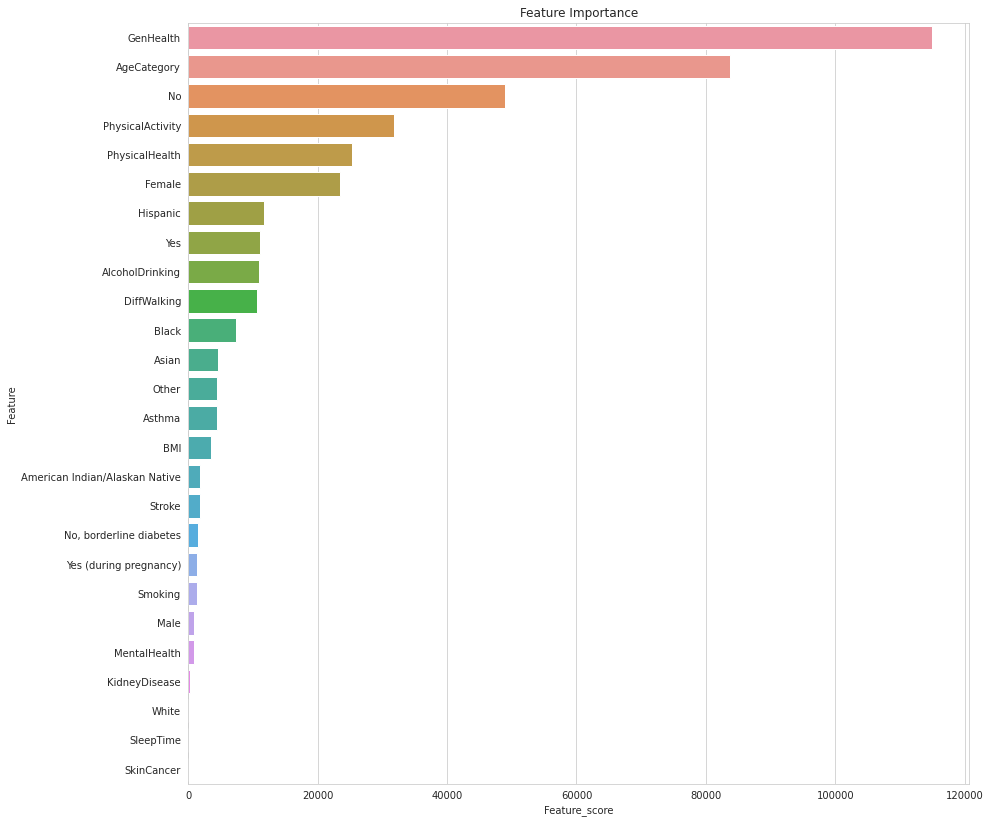

In [135]:
feature_selector = SelectKBest(f_classif).fit(X_res, y_res)

feature_importance = pd.DataFrame({
    "Feature_score": feature_selector.scores_,
    "Feature": X_train.columns
}).sort_values(by="Feature_score", ascending=False)

_, ax = plt.subplots(figsize=(14, 14))
p = sns.barplot(ax=ax, data=feature_importance, x="Feature_score", y="Feature")
_ = p.set_title("Feature Importance")

Судя по графику, самые важные признаки:
1.   GenHealth
2.   AgeCategory
3.   No (Not diabetic)
4.   PhysicalActivity
5.   PhysicalHealth

Что подтверждает предыдущие предположения. Аналогично с самыми ненужными признаками. Нас не интересуют наличие рака кожи, болезней почек, раса и ментальное здоровье.

Что очень интересно - почему-то женский пол оказался ужасно важен. Возможно из-за зависимости, найденной выше (женщины менее подвержены болезням сердца).

Выбросим последние 10.


In [136]:
features_to_drop = feature_importance["Feature"][-10:]
X_res.drop(columns=features_to_drop, inplace=True)
X_test.drop(columns=features_to_drop, inplace=True)

## **Тест трёх алгоритмов**

In [137]:
def cross_validation(X_train: pd.DataFrame, y_train: pd.DataFrame, block_num: int, model):
  metrics = cross_validate(model, X_train, y_train, return_train_score=True, cv=block_num, scoring=['balanced_accuracy', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc'])
  del metrics['fit_time']
  del metrics['score_time']
  
  result = {'Train': {}, 'Validation': {}}
  for cur_metric in metrics:
    if 'test' in cur_metric:
      result['Validation'][cur_metric[5:]] = np.mean(metrics[cur_metric])
    elif 'train' in cur_metric:
      result['Train'][cur_metric[6:]] = np.mean(metrics[cur_metric])
    else:
      raise Exception(f'Invalid Scoring Result: contains {cur_metric}')

  result = pd.DataFrame(result).T
  return result

def plot_metrics(metrics: pd.DataFrame, model_name: str = ""):

  metr_df = metrics
  metr_df.index.name='DataSet'
  metr_df.reset_index(inplace=True)
  metr_df = metr_df.melt(id_vars='DataSet')

  _, ax = plt.subplots(figsize=(15,10))

  ax.set_title(model_name)
  ax.set_xlabel('Metric')
  ax.set_ylabel('Metric Value')
  ax.set(ylim=(0,1))

  sns.set_style("whitegrid")
  sns.barplot(data=metr_df, ax=ax, x='variable', y='value', hue='DataSet', palette=sns.color_palette("muted", 9))
  

Выбор пал на три алгоритма классификации с наростанием сложности и новизны.

### **Логистическая регрессия**

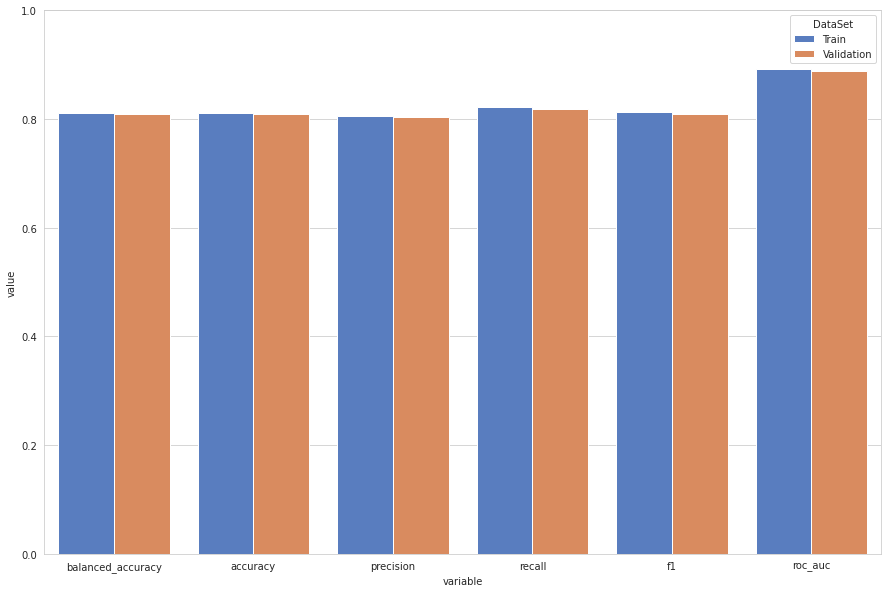

In [138]:
lr_model = LogisticRegression(random_state=RANDOM_STATE, solver='liblinear')
lr_metr = cross_validation(X_res, y_res, 5, lr_model)
plot_metrics(lr_metr)

### **Комментарий**

Отрабатывает на удивление неплохо и на обучающей, и на валидационной выборках, несмотря на простоту самого алгоритма. Достаточно любопытно.

### **Рандомный лес**

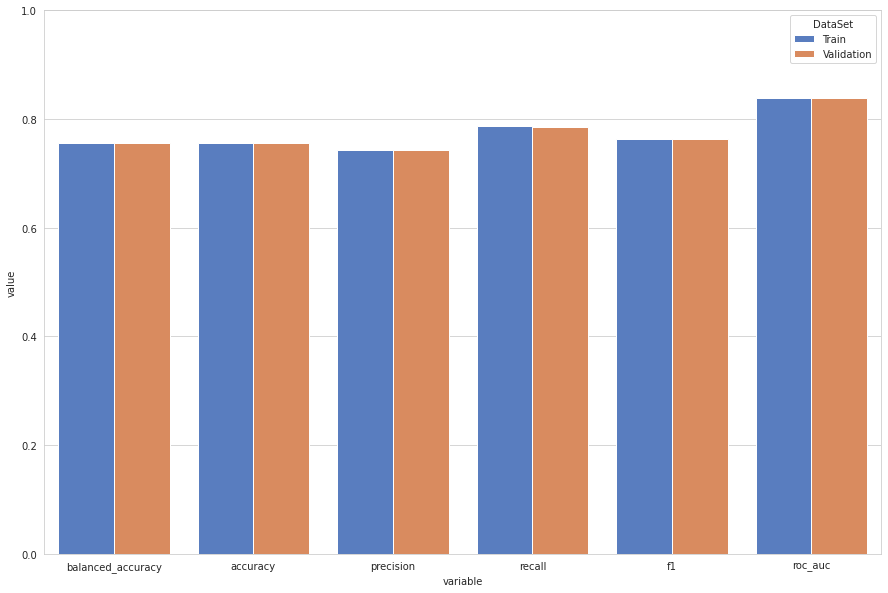

In [139]:
rf_model = RandomForestClassifier(max_depth=2, random_state=RANDOM_STATE)
rf_metr = cross_validation(X_res, y_res, 5, rf_model)
plot_metrics(rf_metr)

### **Комментарий**

Ожидал от леса переобучения, но не получив его, даже удивлён. Однако результаты вышли даже хуже, чем у лог. регрессии. Явно неутешающий результат.

### **XGBoost**

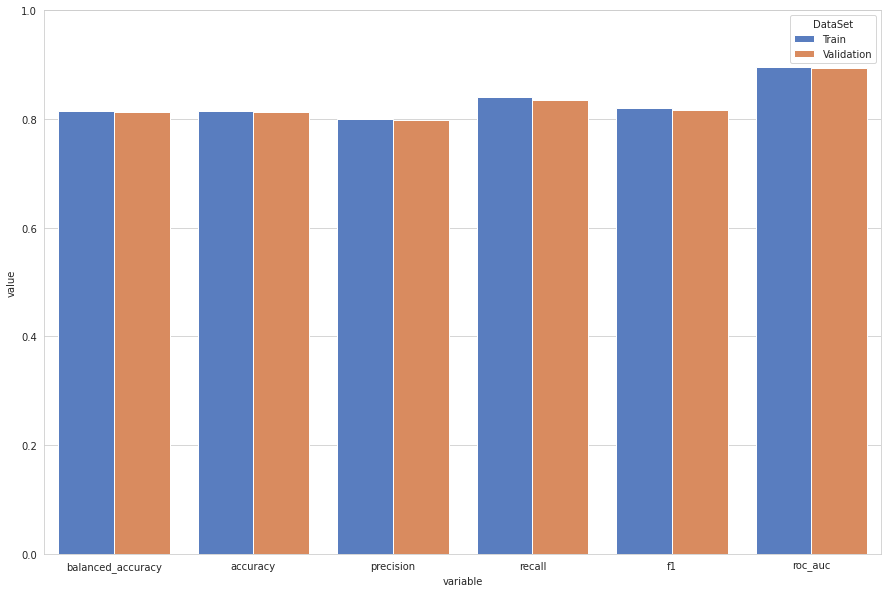

In [140]:
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=RANDOM_STATE)
xgb_metr = cross_validation(X_res, y_res, 5, xgb_model)
plot_metrics(xgb_metr)

### **Комментарий**

Явно лучший результат, что не особо удивительно. Все метрики получили достаточно неплохие значения, которые также незначительно отличаются на тренировочной и валидационной выборках. Подбор гиперпараметров далее будут проводиться на основе XGBoost'а.

## **Подбираем гиперпараметры**

Не будем уходить очень далеко и подберём самые очевидные параметры - n_estimators и max_depth.

In [141]:
def plot_error(x_ticks: np.array, error_vals: np.array, param_name: str = ""):
  _, ax = plt.subplots(figsize=(15,8))
  error_plot = sns.lineplot(data=pd.DataFrame({"Vals": [str(i) for i in x_ticks], "Errors": -error_vals}), x="Vals", y="Errors", ax=ax)
  error_plot.set_title(param_name)
  error_plot.set_ylabel("Error")
  error_plot.set_xlabel("Param Value")


In [143]:
cur_param = "n_estimators"
n_estimators = np.arange(100, 1001, 300)

n_estimators_clf = GridSearchCV(
    xgb.XGBClassifier(objective='binary:logistic', random_state=RANDOM_STATE),
    param_grid = {
        cur_param: n_estimators
    },
    cv = 3,
    scoring = 'neg_log_loss',
    n_jobs=-1)
n_estimators_clf.fit(X_res, y_res)
n_estimators_clf.best_params_

{'n_estimators': 1000}

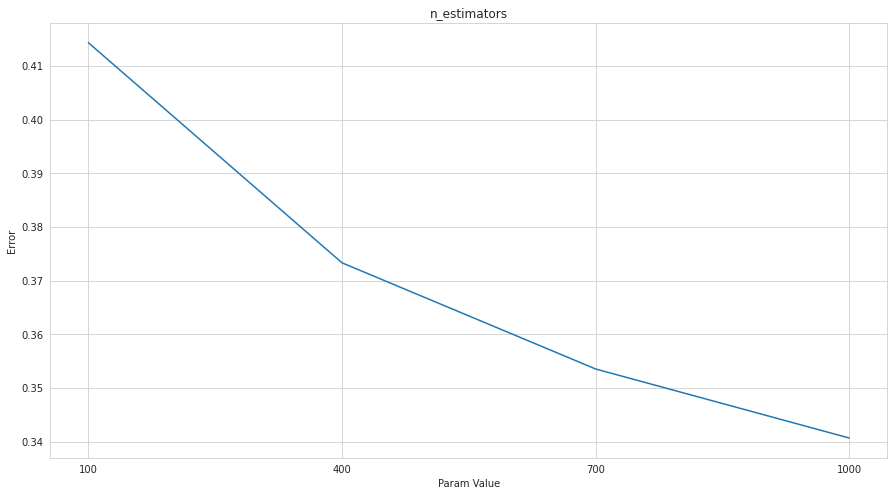

In [144]:
plot_error(n_estimators, np.array(n_estimators_clf.cv_results_["mean_test_score"]), cur_param)

In [145]:
cur_param = "max_depth"
max_depth_vars = np.arange(2, 5)

max_depth_clf = GridSearchCV(
    xgb.XGBClassifier(objective='binary:logistic', n_estimators=n_estimators_clf.best_params_["n_estimators"], random_state=RANDOM_STATE),
    param_grid = {
        cur_param: max_depth_vars
    },
    cv = 3,
    scoring = 'neg_log_loss',
    n_jobs=-1)
max_depth_clf.fit(X_res, y_res)
max_depth_clf.best_params_


{'max_depth': 4}

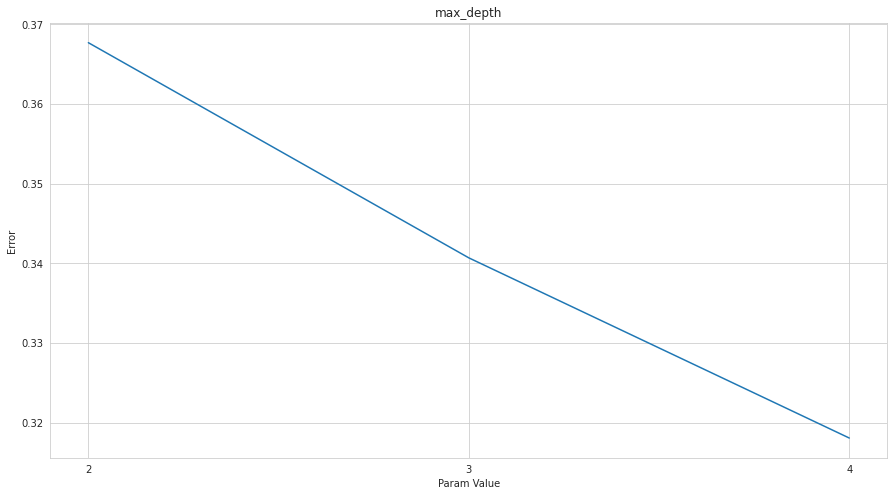

In [146]:
plot_error(max_depth_vars, np.array(max_depth_clf.cv_results_["mean_test_score"]), cur_param)

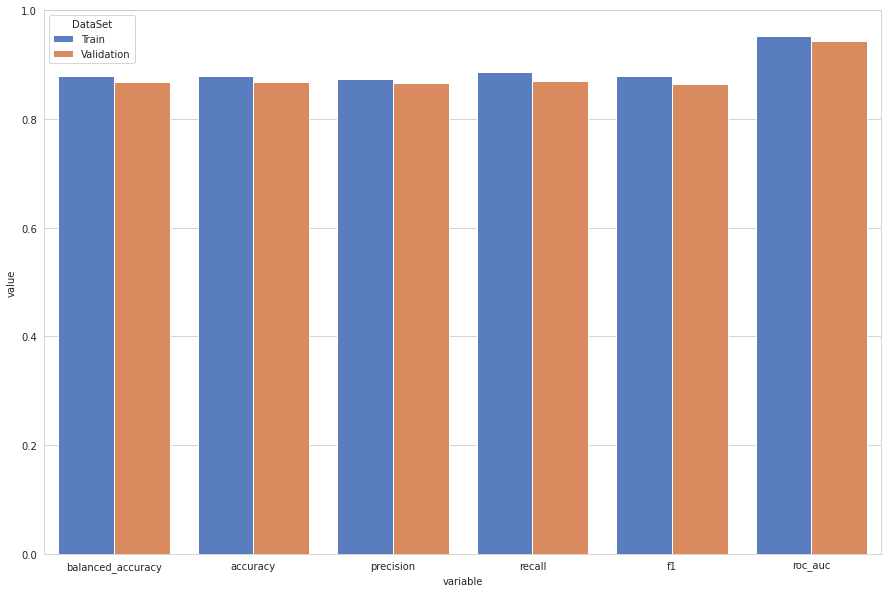

In [147]:
final_xgb_model = xgb.XGBClassifier(objective='binary:logistic', max_depth=max_depth_clf.best_params_["max_depth"], n_estimators=n_estimators_clf.best_params_["n_estimators"], random_state=RANDOM_STATE)
final_xgb_metr = cross_validation(X_res, y_res, 5, final_xgb_model)
plot_metrics(final_xgb_metr)

In [148]:
final_xgb_metr

,DataSet,balanced_accuracy,accuracy,precision,recall,f1,roc_auc
0,Train,0.878689,0.878689,0.872885,0.886416,0.879596,0.952195
1,Validation,0.868259,0.868260,0.867057,0.869703,0.864961,0.943604


In [149]:
final_xgb_model.fit(X_res, y_res)

XGBClassifier(max_depth=4, n_estimators=1000, random_state=42)

In [150]:
y_predicted = final_xgb_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_predicted)}")
print(f"Precision: {precision_score(y_test, y_predicted)}")
print(f"Recall: {recall_score(y_test, y_predicted)}")
print(f"F1-score: {f1_score(y_test, y_predicted)}")
print(f"ROC-AUC score: {roc_auc_score(y_test, y_predicted)}")

Accuracy: 0.8282148711777358
Precision: 0.24050852354810748
Recall: 0.454962833406209
F1-score: 0.31467130382187275
ROC-AUC score: 0.6593017206923144


Text(69.0, 0.5, 'Actual')

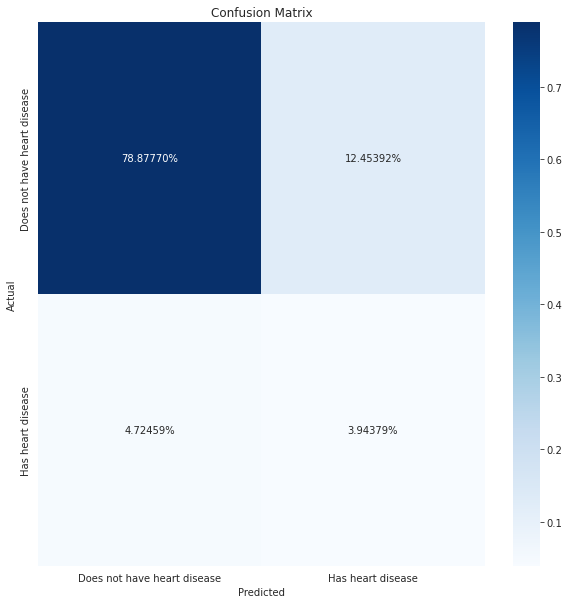

In [151]:
mcm = confusion_matrix(y_test, y_predicted)
labels = ["Does not have heart disease", "Has heart disease"]

_, ax = plt.subplots(figsize=(10, 10))
mcm_plot = sns.heatmap(mcm/mcm.sum(), fmt=".5%", annot=True, ax=ax, cmap='Blues')
mcm_plot.set_title("Confusion Matrix")
mcm_plot.set_xticklabels(labels)
mcm_plot.set_yticklabels(labels)
mcm_plot.set_xlabel("Predicted")
mcm_plot.set_ylabel("Actual")

## **Итоги**

Ну, что-то вышло.

**Про находки данных**

Из очевидного: подтвердились очевидные предположения относительно важности физической нагрузки (доп. физ. активность, сложность ходьбы) и отклонений сна, вреда алкоголя (но не курения, что интересно), а также возраста.

Из более любопытного: отсутствие диабета очень сильно влияет на болезни сердца, не совсем ясно почему; напротив, рак кожи, болезни почек и астма совершенно не влияют на сердце. Пол также имеет некоторую степень влияния (предположительно, женщины встречаются с этим гораздо реже).

Из проигнорированного: раса также в некоторой степени влияет на болезни сердца, однако, мне кажется, это влияние незначительно и не подлежит анализу.

**Про модель**

Вышло далеко не так хорошо, как хотелось бы. Значительно низкие значения в области Recall и Precision - логично, и в F1 - что не есть хорошо. Однако стоит отметить, что ошибки 2 рода достаточно низки (всего 4.7%).

Есть подозрения, что результаты можно значительно улучшить, применив нормализацию, а также продолжив дальнейший подбор гиперпараметров.